In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import feather

In [12]:
version = "f01"

In [13]:
train = feather.read_dataframe(f'../data/processed/train_processed_{version}.feather')
test = feather.read_dataframe(f'../data/processed/test_processed_{version}.feather')

In [14]:
train.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,count_enc_id_31,count_enc_id_32,count_enc_id_33,count_enc_id_34,count_enc_id_35,count_enc_id_36,count_enc_id_37,count_enc_id_38,count_enc_DeviceType,count_enc_DeviceInfo
0,2987000,0.0,68.5,4,4248,0,51,2,43,2,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,2987001,0.0,29.0,4,9979,305,51,3,3,2,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,2987002,0.0,59.0,4,11850,391,51,4,67,3,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,2987003,0.0,50.0,4,8796,468,51,3,18,3,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,2987004,0.0,50.0,1,11687,415,51,3,3,2,...,1067.0,44077.0,1430.0,132185.0,149464.0,267353.0,215149.0,108982.0,118173.0,9.0


In [15]:
train.dtypes

TransactionID             int64
isFraud                 float64
TransactionAmt          float64
ProductCD                 int64
card1                     int64
                         ...   
count_enc_id_36         float64
count_enc_id_37         float64
count_enc_id_38         float64
count_enc_DeviceType    float64
count_enc_DeviceInfo    float64
Length: 499, dtype: object

In [16]:
y = train["isFraud"]
train_id = train["TransactionID"]
test_id = test["TransactionID"]
train = train.drop(["isFraud", "TransactionID", "istrain", "card_no"], axis=1)
test = test.drop(["TransactionID", "istrain", "card_no"], axis=1)

In [17]:
y = y.astype(int)

In [18]:
train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,count_enc_id_31,count_enc_id_32,count_enc_id_33,count_enc_id_34,count_enc_id_35,count_enc_id_36,count_enc_id_37,count_enc_id_38,count_enc_DeviceType,count_enc_DeviceInfo
0,68.5,4,4248,0,51,2,43,2,216,81,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,29.0,4,9979,305,51,3,3,2,226,81,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,59.0,4,11850,391,51,4,67,3,231,81,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,50.0,4,8796,468,51,3,18,3,377,81,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,50.0,1,11687,415,51,3,3,2,321,81,...,1067.0,44077.0,1430.0,132185.0,149464.0,267353.0,215149.0,108982.0,118173.0,9.0


In [19]:
params = {'num_leaves': 128,
         'min_data_in_leaf': 100, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 0,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 0,
         "verbosity": -1}

In [20]:
from sklearn.model_selection import TimeSeriesSplit
folds = TimeSeriesSplit(5)

In [21]:
from sklearn.metrics import roc_curve, auc
def metric_auc(y, pred):
    fpr, tpr, thresholds = roc_curve(y, pred)
    return auc(fpr, tpr)    

In [22]:
from imblearn.under_sampling import RandomUnderSampler

In [25]:
verbose=100
early_stopping_rounds= 3
num_rounds = 3
sampling_strategy=0.2

In [26]:
X = train
y = y
columns = X.columns
#prediction = np.zeros(len(X_test))
feature_importance = pd.DataFrame()
oof = np.zeros(len(X))
categorical_features=[]


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f'fold {fold_ + 1} start')
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=0)
    if type(X) == np.ndarray:
        X_trn = X[columns][trn_idx]
        y_trn = y[trn_idx]
        X_trn, y_trn = rus.fit_resample(X_trn, y_trn)
        trn_data = lgb.Dataset(
            X_trn,
            label= y_trn,
            categorical_feature=categorical_features
        )
        val_data = lgb.Dataset(
            X[columns][val_idx],
            label=y[val_idx],
            categorical_feature=categorical_features
        )
    else:
        X_trn = X[columns].iloc[trn_idx]
        y_trn = y.iloc[trn_idx]
        X_trn, y_trn = rus.fit_resample(X_trn, y_trn)
        trn_data = lgb.Dataset(
            X_trn,
            label=y_trn,
            categorical_feature=categorical_features
        )
        val_data = lgb.Dataset(
            X[columns].iloc[val_idx],
            label=y.iloc[val_idx],
            categorical_feature=categorical_features
        )
    
    model = lgb.train(
        params=params,
        train_set=trn_data,
        num_boost_round=num_rounds,
        valid_sets=[trn_data, val_data],
        verbose_eval=verbose,
        early_stopping_rounds=early_stopping_rounds
    )
    
    if type(X) == np.ndarray:
        oof[val_idx] = model.predict(X[columns][val_idx], num_iteration=model.best_iteration)
    else:
        oof[val_idx] = model.predict(X[columns].iloc[val_idx], num_iteration=model.best_iteration)
    
    #prediction += model.predict(X_test, num_iteration=model.best_iteration)
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = columns
    fold_importance["importance"] = model.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

fold 1 start


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 3 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's auc: 0.908456	valid_1's auc: 0.850184
fold 2 start


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 3 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's auc: 0.907857	valid_1's auc: 0.879177
fold 3 start


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 3 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's auc: 0.899118	valid_1's auc: 0.862267
fold 4 start


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 3 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's auc: 0.887547	valid_1's auc: 0.868014
fold 5 start


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 3 rounds.
Did not meet early stopping. Best iteration is:
[3]	training's auc: 0.886985	valid_1's auc: 0.860023


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'LGB Features (avg over folds)')

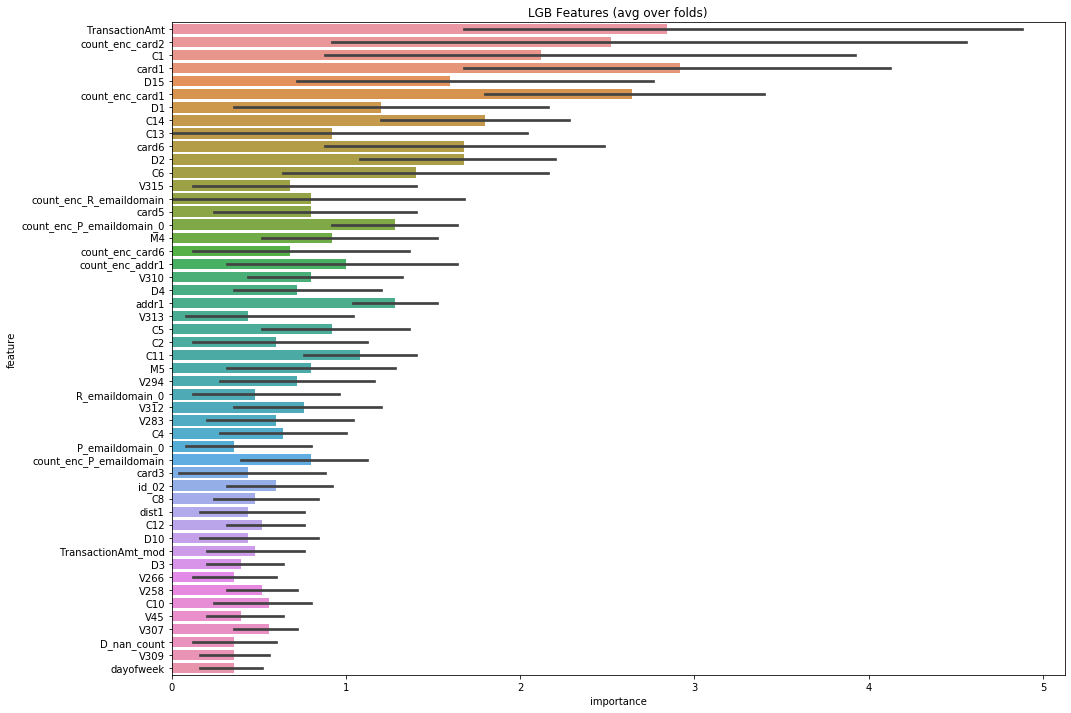

In [28]:
feature_importance["importance"] /= folds.n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance",
    ascending=False
).index[0:50]
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(16,12))

sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LGB Features (avg over folds)')

In [29]:
feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance",
            ascending=False
        )

,importance
feature,
card1,2.92
TransactionAmt,2.84
count_enc_card1,2.64
count_enc_card2,2.52
C1,2.12
C14,1.80
card6,1.68
D2,1.68
D15,1.60


In [30]:
feature_df = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance",
            ascending=False
        )

In [32]:
(feature_df["importance"]  >= 0).sum()

495

In [33]:
feature_list = list(feature_df[feature_df["importance"]  >= 10].index)

In [34]:
#train = train[feature_list]
#test = test[feature_list]

In [36]:
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=0)
X_trn, y_trn = rus.fit_resample(train, y)

trn_data = lgb.Dataset(
    X_trn,
    label= y_trn
)
num_round = 3
model = lgb.train(
    params=params,
    train_set=trn_data,
    num_boost_round=num_round,
    verbose_eval=verbose,
)

In [37]:
predict = model.predict(test, num_iteration=num_round)

In [38]:
predict

array([0.16309018, 0.16358769, 0.1637607 , ..., 0.16338109, 0.16338109,
       0.16423712])

In [39]:
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [40]:
sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [41]:
sub["isFraud"] = predict

In [42]:
sub.head()

,TransactionID,isFraud
0,3663549,0.001427
1,3663550,0.008665
2,3663551,0.001663
3,3663552,0.007389
4,3663553,0.004895


In [43]:
sub.to_csv(f'../model/submit/sub{version}.csv', index=False)

In [39]:
cv_score = 0
leader_board_score = 0
cv_strategy = "timeSeriesSplit5"
submit = "test"

feature_select = 0
under_sample = 0.2

In [40]:
info = {
    "early_stopping_rounds": early_stopping_rounds,
    "num_rounds": num_rounds,
    "feature_select": feature_select,
    "under_sample": under_sample,
    "num_round": num_round
}

/opt/conda/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


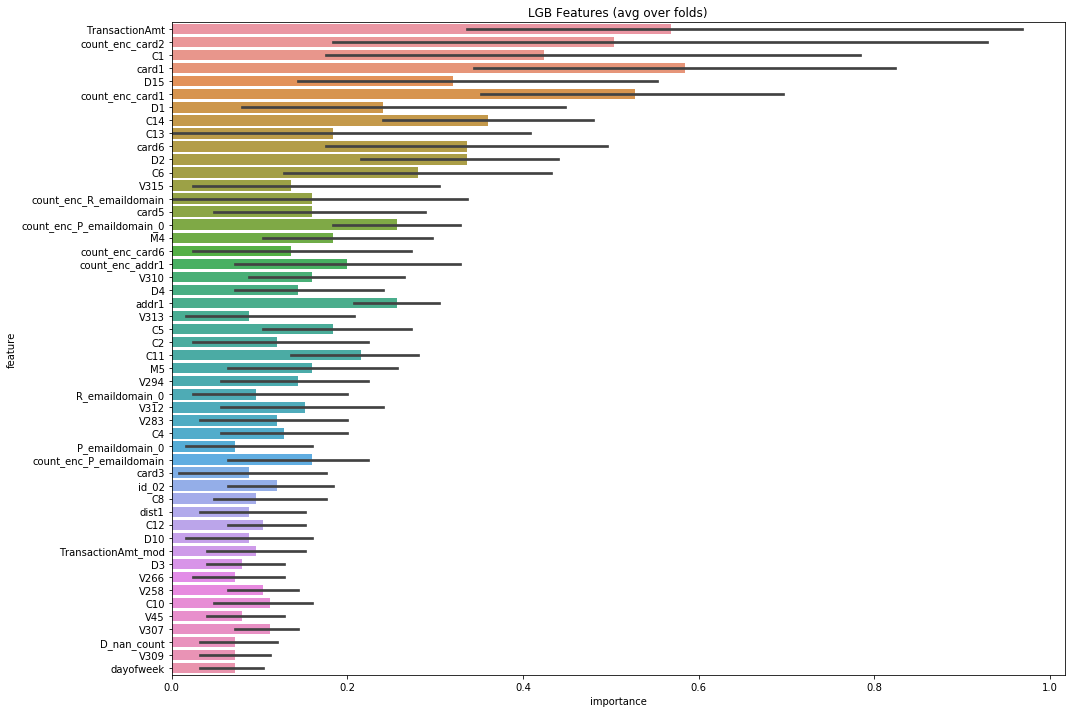

In [41]:
import mlflow
import mlflow.sklearn
import tempfile
import os
import json

mlflow.set_tracking_uri('http://mlflow.wp16005.wing.sysrdc.com')
# アーティファクトアップロードのための設定(アップロード先がs3互換のminioを使用しているため必須)
os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio.wp16005.wing.sysrdc.com'

# S3アカウントの設定(see. https://mlflow.org/docs/latest/tracking.html#amazon-s3)
# とりあえず使うために環境変数を定義
os.environ['AWS_ACCESS_KEY_ID']='mlflowcommon'
os.environ['AWS_SECRET_ACCESS_KEY']='mlflowcommon-secret'
mlflow.set_experiment("IEEE-CIS")
with mlflow.start_run():
    with tempfile.TemporaryDirectory() as dname:
        # lightgbmの設定パラメータ
        save_file = os.path.join(dname, "parameters.json")
        with open(save_file, "w") as f:
            json.dump(params, f)
        mlflow.log_artifact(save_file)
        # そのほかのモデル再現に必要なパラメータ
        save_file = os.path.join(dname, "info.json")
        with open(save_file, "w") as f:
            json.dump(info, f)
        mlflow.log_artifact(save_file)
        # 学習時のfeature iportance
        save_file = os.path.join(dname, "importance.png")
        feature_importance["importance"] /= folds.n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance",
            ascending=False
        ).index[0:50]
        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
        plt.figure(figsize=(16,12))

        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LGB Features (avg over folds)')
        plt.savefig(save_file)
        mlflow.log_artifact(save_file)
    
    mlflow.log_param("cv_strategy", cv_strategy)
    mlflow.log_param("sub", submit)
    
    mlflow.log_metric("auc", cv_score)
    mlflow.log_metric("lb_auc", leader_board_score)
    
    mlflow.sklearn.log_model(model, "model")

In [58]:
params

{'num_leaves': 64,
 'min_data_in_leaf': 100,
 'objective': 'binary',
 'max_depth': -1,
 'learning_rate': 0.1,
 'boosting': 'gbdt',
 'feature_fraction': 0.8,
 'bagging_freq': 1,
 'bagging_fraction': 0.8,
 'bagging_seed': 0,
 'metric': 'auc',
 'lambda_l1': 0.1,
 'random_state': 0,
 'verbosity': -1}